# Assignment Team 12 
* Nithin Dornipadu
* Zeenia Singla

<div style="text-align: right">INFO 6105 Data Sci Engineering Methods and Tools, Week 7 Lecture 1</div>
<div style="text-align: right">Dino Konstantopoulos, 28 February 2022, with material by Chris Fonnesbeck and Cyrille Rossant</div>
<div style="text-align: right"><i>please browse all URLs in this notebook</i></div>

So we learned **probability theory**. Basically, *if you can count* by building your random-variable sets and the predicates you want to apply on the datasets with python, you do not need to know the math behind probability theory (but knowing some of the math is helpful). 

We also did an introduction to **Bayes' formula**, which allows you to invert the precondition and the postcondition on a conditional probability to make probabilities easier to evaluate. That is very useful for data science interviews that involve probability questions. We looked at an example counting M&Ms.

But Bayes' formula will open up a new universe of statistics for us, which we'll get into. For now, let's learn about *classical statistics*. What was invented in the 1800s. All in two notebooks!

<div id="divCheckbox" style="display: none;">
"20102020"[::-1]
</div>

# The Method Of Moments (MOM) 

We'll illustrate the **Method of Moments** (MOM) with ***an example***. When you take a ***bad*** class in statistics, where you don't understand or tend to fall asleep at the helm, it's the ***fault of the professor!***

<br />
<center>
<img src =ipynb.images/asleep.jpg width = 400 />
</center>

A good professor will give you ***interesting problems*** to keep you awake. Then you’ll have an appreciation for how statistics helps us to understand the world. There are many **amazing phenomena** in the world, and we use data science as a tool for exploring them.

## The goal of non-machine-assisted data science
We already know that random-looking datasets actually can have very normal-looking pdfs. So, given a normal-looking pdf, we can generate a lot of different random-lloking datasets.

>**Goal**: Match the histogram of the data to a known pdf (figure out the parameters of that pdf if the pdf is parametric), and then use that pdf to generate data and do prdictions, rather than using the original dataset, because it's a lot easier than interpolation.

So, what Neanderthal data scientists did is to try to match the histogram of datasets to well-known theoretical profiles, and then they can use the theoretical profile (gaussian, gamma, etc.) to simulate data! 

Pretty clever, huh?

Now, with computers, ***we can do the same thing***, i.e. find the best approximation to our empirical histogram and then use libraries like `SciPy` to build simulations of (the process underlying) our data. So we don't need the math, as much as the Neanderthals did. Also, we can do additional things with computers using bayesian statistics, which we'll look into next week.

> **IMPORTANT**: Why do we want to produce data that may *look* different and yet follows the same histogram? Because we theorize that by capturing the histogram, we are modelling the *process* that produced the data, which is *what we're really after*. Plus real-world data has noise, and we don't like noise! Matching the random-looking data with a well-known pdfs has a *smoothing effect*. That is what **data science** is all about.

To understand Neanderthal data scientists better, let's do some labs and try to leverage the parametrized distributions we just learned as potential models to datasets we observe. 

## Lab \#1: Nashville Precipitation

The dataset `nashville_precip.txt` contains NOAA precipitation data for the city of Nashville, Tennessee, measured since 1871. It is a classical dataset, like the iris dataset. Download it from canvas and put it in the right folder (you know..). The gamma distribution is a good fit to aggregated rainfall data, and will be our candidate distribution in this case. We'll use the gamma distribution model for Nashville precipitation to demonstrate the [Method of Moments](https://en.wikipedia.org/wiki/Method_of_moments_(statistics)) (MOM).

The other method is Maximum Likelihood Estimation, which in some cases is intractable without computers. The method-of-moments estimators however can be computed much more quickly and easily. Due to this easy computability, method-of-moments estimates may be used as the first approximation to the solutions of the likelihood equations, and successive improved approximations may then be found by the Newton–Raphson method. 

Let's peek at our data:

In [2]:
import pandas as pd

In [3]:
precip = pd.read_table("data4/nashville_precip.txt", index_col=0, na_values='NA', delim_whitespace=True)
precip.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1871,2.76,4.58,5.01,4.13,3.30,2.98,1.58,2.36,0.95,1.31,2.13,1.65
1872,2.32,2.11,3.14,5.91,3.09,5.17,6.10,1.65,4.50,1.58,2.25,2.38
1873,2.96,7.14,4.11,3.59,6.31,4.20,4.63,2.36,1.81,4.28,4.36,5.94
1874,5.22,9.23,5.36,11.84,1.49,2.87,2.65,3.52,3.12,2.63,6.12,4.19
1875,6.15,3.06,8.14,4.22,1.73,5.63,8.12,1.60,3.79,1.25,5.46,4.30


In the year 1871, in the month of January, Nashville saw 2.76 inches of rainfall.

### 1. Data Exploration: The Histogram

Let's do some data exploration with the ***histogram*** of precipitations, month by month. The histogram of a specific mootn tells us what's the most frequent number of inches of rain from 1871 onward.

</br >
<center>
<img src="ipynb.images/rainfall.jpeg" width=400 />
</center>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

```
_ = precip.hist(sharex=True, sharey=True, grid=False)
plt.tight_layout()
```

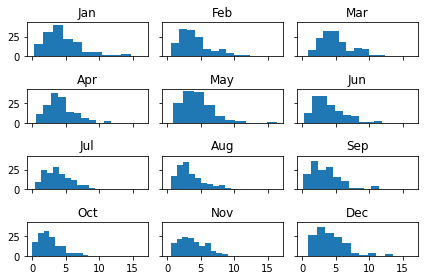

In [5]:
_ = precip.hist(sharex=True, sharey=True, grid=False)
plt.tight_layout()

#_ = precip('Jan').hist()

The first step is recognizing what sort of distribution to fit our data to. A couple of observations:

1. The data is *skewed*, with a longer tail to the right than to the left
2. The data is positive-valued, since they are measuring rainfall
3. The data is continuous

Even just by ***eyeballing*** the theoretical pdfs we introduced (normal, Poisson, etc.) , ***even if you did not know what the Gamma distribution is usually used for***, a good option appears to be the **gamma distribution**: The curves look like ***Gaussians with long tails***. That's a Gamma!

<br />
<div style="font-size: 120%;">  
$$x \sim \text{Gamma}(\alpha, \beta) = \frac{x^{\alpha-1}e^{- x/\beta}}{\beta^{\alpha}\Gamma(\alpha)}$$
</div>

### 2. Data Cleansing 

***Wait***, there's something ***wrong*** with our data.. if you open it in a text editor, you will find a value of **NA** for October of 1963 (take a look). 

So we have to do some **data cleansing** first. That step is called **exploratory data cleansing** (EDA). *Always* do that, first.

Given what we are trying to do, it is ***sensible*** to fill in the missing value with the average of the available values (another option would have been the average of the months of September and November 1963). Filling in with 0 would be a *bad idea*.

```
precip.fillna(value={'Oct': precip.Oct.mean()}, inplace=True)
precip
```

In [6]:
precip.fillna(value={'Oct': precip.Oct.mean()}, inplace=True)
precip

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1871,2.76,4.58,5.01,4.13,3.30,2.98,1.58,2.36,0.95,1.31,2.13,1.65
1872,2.32,2.11,3.14,5.91,3.09,5.17,6.10,1.65,4.50,1.58,2.25,2.38
1873,2.96,7.14,4.11,3.59,6.31,4.20,4.63,2.36,1.81,4.28,4.36,5.94
1874,5.22,9.23,5.36,11.84,1.49,2.87,2.65,3.52,3.12,2.63,6.12,4.19
1875,6.15,3.06,8.14,4.22,1.73,5.63,8.12,1.60,3.79,1.25,5.46,4.30
...,...,...,...,...,...,...,...,...,...,...,...,...
2007,3.32,1.84,2.26,2.75,3.30,2.37,1.47,1.38,1.99,4.95,6.20,3.83
2008,4.76,2.53,5.56,7.20,5.54,2.21,4.32,1.67,0.88,5.03,1.75,6.72
2009,4.59,2.85,2.92,4.13,8.45,4.53,6.03,2.14,11.08,6.49,0.67,3.99


### 3. Method of Moments

The **method of moments** simply assigns the **empirical** (coming from the data) **mean** and **variance** to their **theoretical counterparts** (coming from the *model*, in this case the Gamma!), so that we can ***solve for the parameters*** of the Gamma!

So, for the gamma distribution, the mean and variance turn out to be (analytically derived):

<br />
<div style="font-size: 120%;">  
$$ \hat{\mu} = \bar{X} = \alpha \beta $$
$$ \hat{\sigma}^2 = S^2 = \alpha \beta^2 $$
</div>

So, if we solve for these parameters, we can use a gamma distribution to describe our data, with parameters:

<br />
<div style="font-size: 120%;">  
$$ \alpha = \frac{\bar{X}^2}{S^2}, \, \beta = \frac{S^2}{\bar{X}} $$
</div>

($\bar{X}$ is the mean, while $S^2$ is the variance of each column of the dataset).

Now, let's calculate the sample ***moments of interest***: the **means** and **variances** *month by month*, using good ol' `pandas`:
```
precip_mean = precip.mean()
precip_mean
```

```
precip_var = precip.var()
precip_var
```

In [8]:
precip_mean = precip.mean()
precip_mean

Jan    4.523688
Feb    4.097801
Mar    4.977589
Apr    4.204468
May    4.325674
Jun    3.873475
Jul    3.895461
Aug    3.367305
Sep    3.377660
Oct    2.610500
Nov    3.685887
Dec    4.176241
dtype: float64

In [9]:
precip_var = precip.var()
precip_var

Jan    6.928862
Feb    5.516660
Mar    5.365444
Apr    4.117096
May    5.306409
Jun    5.033206
Jul    3.777012
Aug    3.779876
Sep    4.940099
Oct    2.761383
Nov    3.679274
Dec    5.418022
dtype: float64

We then use these moments to estimate $\alpha$ and $\beta$ for each month:
```python
alpha_mom = ...
beta_mom = ...
alpha_mom, beta_mom
```

<div style="display:none;">
alpha_mom = precip_mean ** 2 / precip_var
beta_mom = precip_var / precip_mean
</div>

In [12]:
alpha_mom = (precip_mean**2)/precip_var
alpha_mom

Jan    2.953407
Feb    3.043866
Mar    4.617770
Apr    4.293694
May    3.526199
Jun    2.980965
Jul    4.017624
Aug    2.999766
Sep    2.309383
Oct    2.467861
Nov    3.692511
Dec    3.219070
dtype: float64

In [14]:
beta_mom = (precip_var)/precip_mean
beta_mom

Jan    1.531684
Feb    1.346249
Mar    1.077920
Apr    0.979219
May    1.226724
Jun    1.299403
Jul    0.969593
Aug    1.122522
Sep    1.462581
Oct    1.057799
Nov    0.998206
Dec    1.297344
dtype: float64

Then, use the `gamma.pdf` function in `scipy.stats.distributions` to plot the distributions implied by the calculated alphas and betas. 

For example, here is `January` (and note that scipy's gamma is the *gamma distribution*, not the $\Gamma$ function that interpolates $n!$ to real numbers, even though the $\Gamma$ function figures in the denominator of the gamma distribution):

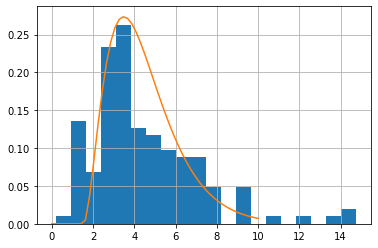

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats.distributions import gamma

precip.Jan.hist(density=True, bins=20)
plt.plot(np.linspace(0, 10), gamma.pdf(np.linspace(0, 10), alpha_mom[0], beta_mom[0]))

Not bad for january :-) Looping over all months now, create a grid of plots for the distribution of rainfall, using the gamma distribution. Here is how you can create a grid of plots:

```python
axs = precip.hist(density=True, figsize=(12, 8), sharex=True, sharey=True, bins=15, grid=True)

for ax in axs.ravel():
    
    # Get month
    m = ax.get_title()
    
    # Plot fitted distribution
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, gamma.pdf(x, alpha_mom[m], beta_mom[m]))
    
    # Annotate with parameter estimates
    label = 'alpha = {0:.2f}\nbeta = {1:.2f}'.format(alpha_mom[m], beta_mom[m])
    ax.annotate(label, xy=(10, 0.2))
    
plt.tight_layout()
```

You may have to change `normed` attribute in the code to `density`

<div style="display:none;">
axs = precip.hist(normed=True, figsize=(12, 8), sharex=True, sharey=True, bins=15, grid=True)

for ax in axs.ravel():
    
    # Get month
    m = ax.get_title()
    
    # Plot fitted distribution
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, gamma.pdf(x, alpha_mom[m], beta_mom[m]))
    
    # Annotate with parameter estimates
    label = 'alpha = {0:.2f}\nbeta = {1:.2f}'.format(alpha_mom[m], beta_mom[m])
    ax.annotate(label, xy=(10, 0.2))
    
plt.tight_layout()
</div>

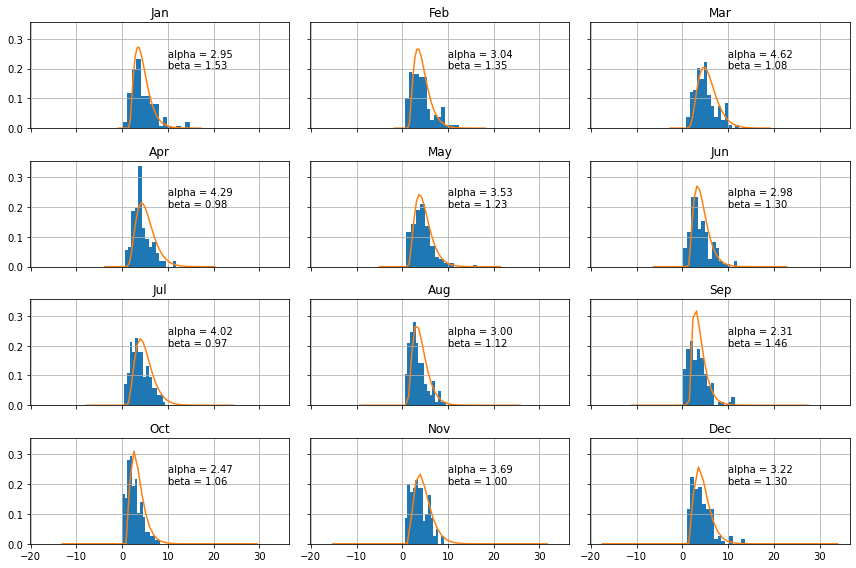

In [19]:
axs = precip.hist(density=True, figsize=(12, 8), sharex=True, sharey=True, bins=15, grid=True)

for ax in axs.ravel():
    
    # Get month
    m = ax.get_title()
    
    # Plot fitted distribution
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, gamma.pdf(x, alpha_mom[m], beta_mom[m]))
    
    # Annotate with parameter estimates
    label = 'alpha = {0:.2f}\nbeta = {1:.2f}'.format(alpha_mom[m], beta_mom[m])
    ax.annotate(label, xy=(10, 0.2))
    
plt.tight_layout()

Good job, that was **data science**! You built a model from precipitation data, and now when somebody asks you to about weather for a certain month, you can give a good (historical) prediction.
<left>
<img src="ipynb.images/good-job-bear.png" width=200 />
</left>

### 4. Conclusion

In math, a **moment** is a specific quantitative measure of the ***shape of a set of points***. 

The *zeroth* moment is the total mass, the *first* moment is the center of mass, the *second* moment is rotational inertia. Oops.. this is not mechanics 101, it's statistics 101...

So, the *zeroth* moment is total probability, *first* moment is the [mean](https://en.wikipedia.org/wiki/Mean), *second* moment is the [variance](https://en.wikipedia.org/wiki/Variance), *third* moment is the [skewness](https://en.wikipedia.org/wiki/Skewness), *fourth* moment is the [kurtosis](https://en.wikipedia.org/wiki/Kurtosis). And you can keep on going...

For a distribution of mass or probability on a bounded interval, the collection of all the moments (of all orders, from 0 to $\infty$) ***uniquely determines the distribution***. This is related to [Taylor's approximation theorem](https://en.wikipedia.org/wiki/Taylor%27s_theorem).

Minimum number of moments we need in the **Method of Moments** equal the ***number of the parameters in the estimator***! For each moment, we equate the moment of the ***model + parameters*** to the moment of the dataset. That gives us ***one*** equation for the parameters. We will need as many equations (thus moments) as there are parameters!

The method of Moments is ***easy-peasy***, as long as we have analytic formulas for the moments for the model distribution (which we usually do, *that is why* they are **models**). 

But they're usually *not* the most efficient estimators.

Next, we look at Maximum Likelihood Estimation (MLE), which is a little bit harder to understand because we need to learn some more math...
>**Note**: That math will be extremely useful for us though, because it's the basis of Machine Learning.

# Homework

Finish the homework in this notebook.

Find a simple **one-humped** dataset and model it by matching one of the pdfs we learned about today. Find the most likely parameters of your pdf using MOM. Use the model to do a prediction.

***You will work in teams of 2***. Your TAs will assign you in working teams.

Please find an ***original dataset***. Don't use a boring dataset that everyone can easily google for :-)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
from scipy.stats.distributions import norm

In [5]:
df = pd.read_csv("GlobalLandTemperaturesByMajorCity.csv")

In [6]:
grouped_data = {}

for name, group in df.groupby('City'):
    group.fillna(value={'AverageTemperature': group.AverageTemperature.mean()}, inplace=True)
    grouped_data[name] = group

In [7]:
df_Abidjan_new = grouped_data['Abidjan']

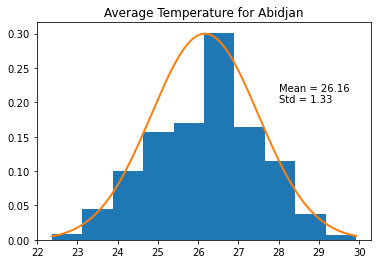

In [43]:
(counts, bins) = np.histogram(df_Abidjan_new['AverageTemperature'])

x = np.linspace(df_Abidjan_new['AverageTemperature'].min(), df_Abidjan_new['AverageTemperature'].max(), num=1977)
mu, std = norm.fit(df_Abidjan_new['AverageTemperature'])
p = norm.pdf(x, mu, std) 
factor = 0.00056
pyplot.hist(bins[:-1], bins, weights=factor*counts)
plt.plot(x, p, linewidth=2) 

plt.title('Average Temperature for Abidjan')
label = 'Mean = {0:.2f}\nStd = {1:.2f}'.format(mu, std)
plt.annotate(label, xy=(28, 0.2))
pyplot.show()

### Most likely parameters of the normal pdf used are: Mean and Standard Deviation

### Probability of City Abidjan having given below Temperatures

In [44]:
avg_temp_test=list(range(20,31))

for avg_temp_test in avg_temp_test:
    mu, std = norm.fit(df_Abidjan_new['AverageTemperature'])
    print("Probability of Abidjan having temperature ", avg_temp_test, ":", norm.pdf(avg_temp_test, mu, std))

Probability of Abidjan having temperature  20 : 6.55002223008003e-06
Probability of Abidjan having temperature  21 : 0.0001606400194361279
Probability of Abidjan having temperature  22 : 0.0022393007083504057
Probability of Abidjan having temperature  23 : 0.017742662125928493
Probability of Abidjan having temperature  24 : 0.07990479517851402
Probability of Abidjan having temperature  25 : 0.20453827938957841
Probability of Abidjan having temperature  26 : 0.29759391673236113
Probability of Abidjan having temperature  27 : 0.2461054299061655
Probability of Abidjan having temperature  28 : 0.11568206638352445
Probability of Abidjan having temperature  29 : 0.03090712260253766
Probability of Abidjan having temperature  30 : 0.004693521456271198
